# Generating Synthetic Chest X-rays

In this notebook, we train a Generative Adversarial Network to create synthetic chest x-rays using the NIH Chest X-ray dataset.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For reproducibility
seed = 2022
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Preparing the data

We already performed some preprocessing steps to the original dataset.

In [3]:
csv_path = "../input/preprocess-nih-chest-full-64/out/info.csv"
img_path = "../input/preprocess-nih-chest-full-64/out/images/"
df = pd.read_csv(csv_path)
df.head()

,Image Index,Male,AP,Edema,Infiltration,Nodule,Pneumothorax,Consolidation,Effusion,Pneumonia,Mass,Pleural_Thickening,Cardiomegaly,No Finding,Atelectasis,Fibrosis,Hernia,Emphysema
0,00000001_000.jpg,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,00000001_001.jpg,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,00000001_002.jpg,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,00000002_000.jpg,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


We choose which aspects of the images we are interested in controlling. We can feed the labels to the GAN as a prompt.

In [4]:
labels_target = ['Cardiomegaly', 'Effusion', 'Infiltration']
labels_target.extend(['Male', 'AP'])
labels_target

['Cardiomegaly', 'Effusion', 'Infiltration', 'Male', 'AP']

In [5]:
# # Uncomment if you want to use all labels
# labels = list(df.columns)[3:]
# labels_target = labels
# labels_target.pop(labels_target.index('No Finding'))
# labels_target.extend(['Male', 'AP'])
# labels_target

In [6]:
df['Label'] = df[labels_target].applymap(lambda x: [x]).sum(axis=1)
df['Filename'] = df['Image Index'].map(lambda x: img_path+x)

In [7]:
df.head()

,Image Index,Male,AP,Edema,Infiltration,Nodule,Pneumothorax,Consolidation,Effusion,Pneumonia,Mass,Pleural_Thickening,Cardiomegaly,No Finding,Atelectasis,Fibrosis,Hernia,Emphysema,Label,Filename
0,00000001_000.jpg,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[1, 0, 0, 1, 0]",../input/preprocess-nih-chest-full-64/out/imag...
1,00000001_001.jpg,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,"[1, 0, 0, 1, 0]",../input/preprocess-nih-chest-full-64/out/imag...
2,00000001_002.jpg,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,"[1, 1, 0, 1, 0]",../input/preprocess-nih-chest-full-64/out/imag...
3,00000002_000.jpg,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 1, 0]",../input/preprocess-nih-chest-full-64/out/imag...
4,00000003_000.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0]",../input/preprocess-nih-chest-full-64/out/imag...


In [8]:
def load_img(filename):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=1)
    img /= 255  
    img = 2 * img - 1
    return img

In [9]:
x_train = tf.data.Dataset.from_tensor_slices(list(df['Filename'])).map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
y_train = tf.data.Dataset.from_tensor_slices(list(df['Label']))

In [10]:
dataset = tf.data.Dataset.zip((x_train, y_train)).shuffle(1024).batch(128)

We inspect a sample from the training images.

In [11]:
def plot_real(dataset, path='', num_images=4):
    
    plt.figure(figsize=(num_images*4, 4), facecolor='k')
    plt.axis('off')
    real_images, _ = next(iter(dataset))
    assert num_images < real_images.shape[0]
    real_images = (real_images + 1) / 2
    real_images = tf.concat([real_images[i,:,:,0] for i in range(num_images)], axis=1)
    plt.imshow(real_images, cmap='gray')
    plt.savefig(path)

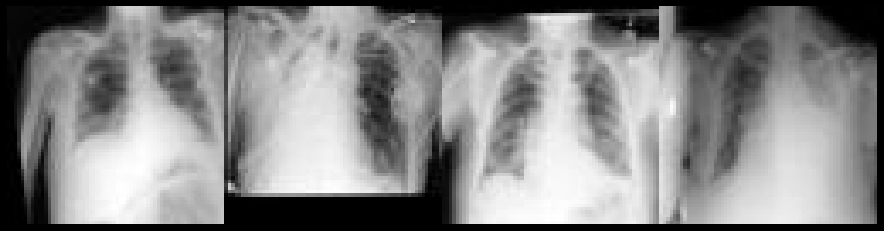

In [12]:
plot_real(dataset, 'real.png')

## Creating the GAN
In a GAN, two deep neural networks compete. The generator maps an input noise vector `z` to the image domain producing realistic samples that fool the discriminator. On the other hand, the discriminator tries to distinguish between the real and the generated samples.  
We implement a version of the `WGAN-GP` model introduced in [the paper by Gulrajani et al.](https://arxiv.org/abs/1704.00028).

In [13]:
class chestGAN(tf.keras.Model):
    
    def __init__(self, discriminator, generator, latent_dim=512, num_labels=0):
        
        super(chestGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.clf_loss_tracker = tf.keras.metrics.Mean(name='classifier_loss"')
        self.ssim_tracker = tf.keras.metrics.Mean(name="ssim")
        
        self.config = {
            'lambda_gp': 0,
            'lambda_drift': 0,
            'lambda_clf': 0,
            'd_steps': 1,
        }
        

    @property
    def metrics(self):
        
        if self.config['lambda_clf'] > 0:
            return [self.gen_loss_tracker, self.disc_loss_tracker, self.clf_loss_tracker, self.ssim_tracker]
        
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.ssim_tracker]
    
        
    def compile(self, d_optimizer, g_optimizer, loss_fn, clf_loss_fn=None, mode='dcgan'):
        
        super(chestGAN, self).compile()
        
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.clf_loss_fn = clf_loss_fn
        self.mode = mode        
            
        if self.mode.find('wgan') >= 0:
            assert self.loss_fn.name == "wasserstein", "Please compile with the Wassertein Loss!"
            self.config['d_steps'] = 5
            self.config['lambda_drift'] = 1e-3
            if self.mode.find('gp') >= 0:
                self.config['lambda_gp'] = 10
        else:
            assert self.loss_fn.name != "wasserstein", "Please compile with a different adversarial loss!"

        if self.mode.find('acgan') < 0:
            assert not self.num_labels, 'mode and num_labels are incompatible'
        else:
            assert self.num_labels, 'mode and num_labels are incompatible'
            self.config['lambda_clf'] = 10
                
        print('Training configuration:', self.config)
       
    
    def get_labels(self, predictions, real=True):
        if self.loss_fn.name == "wasserstein":
            if real:
                labels = -tf.ones_like(predictions)
            else:
                labels = tf.ones_like(predictions)
        else:
            if real:
                labels = tf.ones_like(predictions)
            else:
                labels = tf.zeros_like(predictions)
        return labels


    def train_step(self, data):
        
        lambda_gp = self.config['lambda_gp']
        lambda_drift = self.config['lambda_drift']
        lambda_clf = self.config['lambda_clf'] 
        d_steps = self.config['d_steps']    
        
        real_images, target_labels = data
        
        prompt = tf.expand_dims(tf.expand_dims(tf.cast(target_labels, tf.float32), axis=1), axis=2)
        
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        
        for _ in range(d_steps):
            
            z = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
            gen_in = tf.concat([z, prompt], axis=-1) if lambda_clf > 0 else z
            generated_images = self.generator(gen_in)

            with tf.GradientTape() as tape:

                predictions_real = self.discriminator(real_images)
                predictions_gen = self.discriminator(generated_images)

                labels_real = self.get_labels(predictions_real[:, 0])
                labels_gen = self.get_labels(predictions_gen[:, 0], False)

                d_loss_real = self.loss_fn(labels_real, predictions_real[:, 0])
                d_loss_gen = self.loss_fn(labels_gen, predictions_gen[:, 0])
                
                d_loss = d_loss_real + d_loss_gen
                
                if lambda_gp > 0:

                    epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
                    interpolates = (1-epsilon)* real_images + epsilon * generated_images

                    with tf.GradientTape() as gp_tape:

                        gp_tape.watch(interpolates)
                        predictions = self.discriminator(interpolates)[:, 0]

                    grads_gp = gp_tape.gradient(predictions, [interpolates])[0]

                    norm = tf.sqrt(tf.reduce_sum(tf.square(grads_gp), axis=[1, 2, 3]))
                    gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)   

                    d_loss += lambda_gp * gradient_penalty 
                
                if lambda_drift > 0:
                    
                    drift_penalty = tf.reduce_mean(predictions_real[:, 0] ** 2)
                    d_loss += lambda_drift * drift_penalty 
                    
                if lambda_clf > 0:
                    
                    clf_loss_disc = self.clf_loss_fn(target_labels, predictions_real[:, 1:]) \
                                    + self.clf_loss_fn(target_labels, predictions_gen[:, 1:])
                    d_loss += lambda_clf * clf_loss_disc


            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            
            self.disc_loss_tracker.update_state(d_loss)
            if lambda_clf > 0:
                self.clf_loss_tracker.update_state(clf_loss_disc)
        
        # Train generator

        z = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
        gen_in = tf.concat([z, prompt], axis=-1) if lambda_clf > 0 else z

        with tf.GradientTape() as tape:
            
            fake_images = self.generator(gen_in)
            predictions = self.discriminator(fake_images)
            fake_labels = self.get_labels(predictions[:, 0])
            g_loss = self.loss_fn(fake_labels, predictions[:, 0])
            
            if lambda_clf > 0:
                clf_loss_gen = self.clf_loss_fn(target_labels, predictions[:, 1:])
                g_loss += lambda_clf * clf_loss_gen
                
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )
        
        self.gen_loss_tracker.update_state(g_loss)
        if lambda_clf > 0:
            self.clf_loss_tracker.update_state(clf_loss_gen)
        
        # Compute Structural Similarity Index between real and fake images
        ssim = tf.reduce_mean(tf.image.ssim((real_images + 1) / 2, (fake_images + 1) / 2, 1), axis=0)            
        self.ssim_tracker.update_state(ssim)

        if lambda_clf > 0:
            return {
                "g_loss": self.gen_loss_tracker.result(),
                "d_loss": self.disc_loss_tracker.result(),
                "clf_loss": self.clf_loss_tracker.result(),
                "ssim": self.ssim_tracker.result()
            }
        
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "ssim": self.ssim_tracker.result()
        }
    
    def show_fake(self, path='', num_images=4, label=None, z=[]):
        
        if not label:
            label = self.num_labels * [0]  # Healthy female - PA view
        elif self.num_labels:
            assert len(label) == self.num_labels
            
        plt.figure(figsize=(num_images*4, 4), facecolor='k')
        plt.axis('off')
        
        prompt = tf.reshape(tf.cast(label, tf.float32), (1, -1))
        prompt = tf.expand_dims(tf.expand_dims(prompt, axis=1), axis=2)
        prompt = tf.tile(prompt, [num_images, 1, 1 ,1])
        
        if len(z) == 0:
            z = tf.random.normal(shape=(num_images, 1, 1, self.latent_dim))
        gen_in = tf.concat([z, prompt], axis=-1) if self.num_labels else z
        fake_images = self.generator(gen_in)
        fake_images = (fake_images + 1) / 2
        fake_images = tf.concat([fake_images[i,:,:,0] for i in range(num_images)], axis=1)
        plt.imshow(fake_images, cmap='gray')
        plt.savefig(path)

In [14]:
class Wasserstein(tf.keras.losses.Loss):
    
    def __init__(self):
        super(Wasserstein, self).__init__(name='wasserstein')
    
    def call(self, y_true, y_pred):
        return tf.reduce_mean(y_true*y_pred, axis=-1)

In [15]:
num_labels = len(labels_target)  # Set to zero for unconditional generation
# num_labels = 0

In [16]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2), input_shape= (64, 64, 1)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(512, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.LayerNormalization(axis=[1,2,3]),
    tf.keras.layers.Conv2D(1+num_labels, 3, 2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.GlobalAveragePooling2D()
])

In [17]:
generator = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(512, 3, 2, padding='same', activation='relu', input_shape= (1, 1, 512+num_labels)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='tanh'),
])

In [18]:
chest_gan = chestGAN(
    discriminator=discriminator, generator=generator, num_labels=num_labels
)

## Training the GAN

In [19]:
chest_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    loss_fn=Wasserstein(),
    clf_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    mode = 'wgangp+acgan'  # Set to 'wgangp' for unconditional generation
)

Training configuration: {'lambda_gp': 10, 'lambda_drift': 0.001, 'lambda_clf': 10, 'd_steps': 5}


In [20]:
class ShowFake(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            self.model.show_fake(f'img-epoch{epoch}.png')

Epoch 1/100
876/876 [==============================] - 590s 623ms/step - g_loss: 2.4554 - d_loss: 26.1564 - clf_loss: 0.7479 - ssim: 0.3276
Epoch 2/100
876/876 [==============================] - 257s 293ms/step - g_loss: -3.2540 - d_loss: -7.2088 - clf_loss: 0.3838 - ssim: 0.3686
Epoch 3/100
876/876 [==============================] - 255s 290ms/step - g_loss: -3.3830 - d_loss: -6.3397 - clf_loss: 0.2878 - ssim: 0.3715
Epoch 4/100
876/876 [==============================] - 254s 289ms/step - g_loss: -3.9490 - d_loss: -5.6872 - clf_loss: 0.2575 - ssim: 0.3790
Epoch 5/100
876/876 [==============================] - 254s 290ms/step - g_loss: -4.3235 - d_loss: -5.3510 - clf_loss: 0.2314 - ssim: 0.3795
Epoch 6/100
876/876 [==============================] - 261s 297ms/step - g_loss: -4.7061 - d_loss: -4.9311 - clf_loss: 0.2179 - ssim: 0.3782
Epoch 7/100
876/876 [==============================] - 253s 288ms/step - g_loss: -4.7162 - d_loss: -4.5045 - clf_loss: 0.2085 - ssim: 0.3791
Epoch 8/100
87

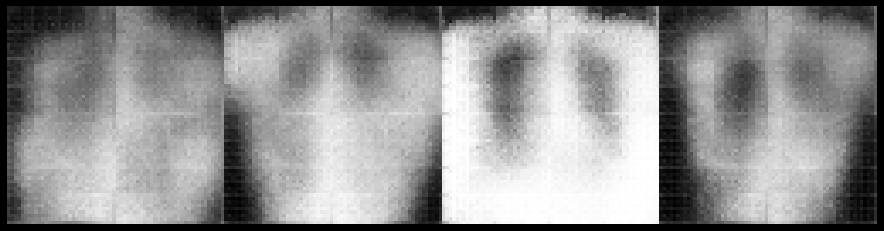

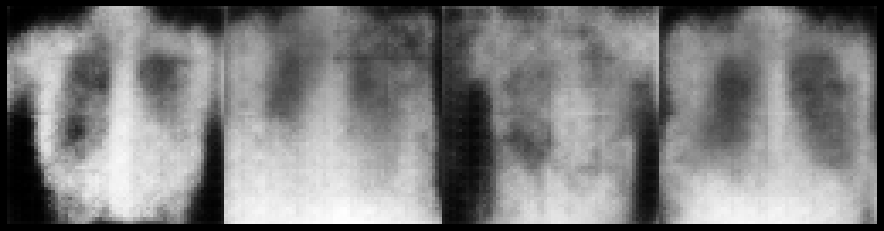

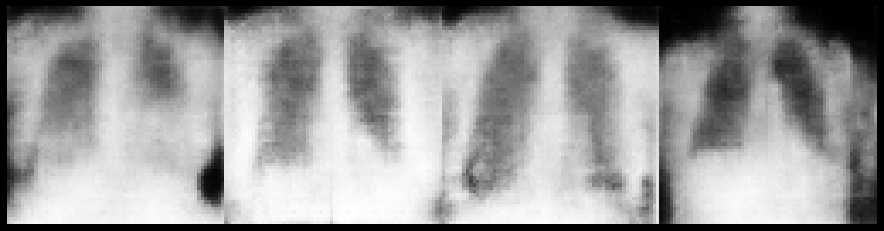

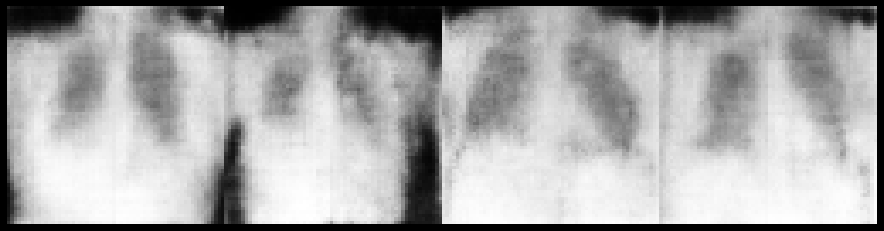

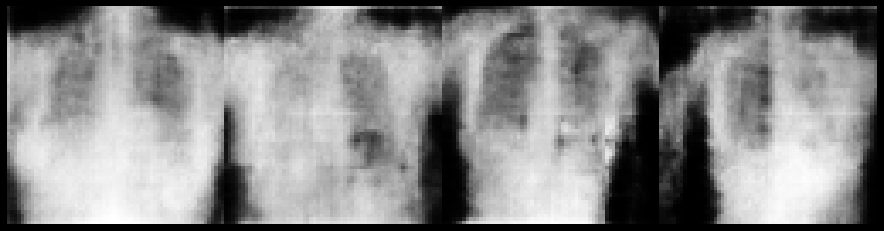

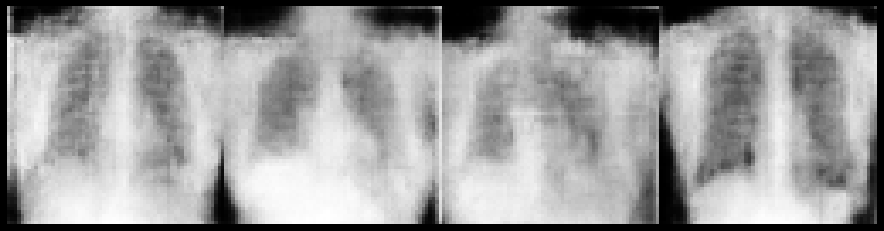

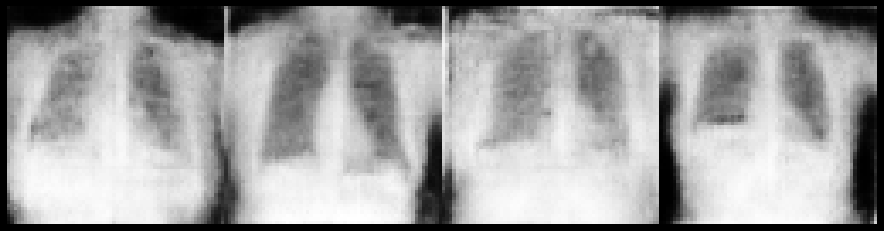

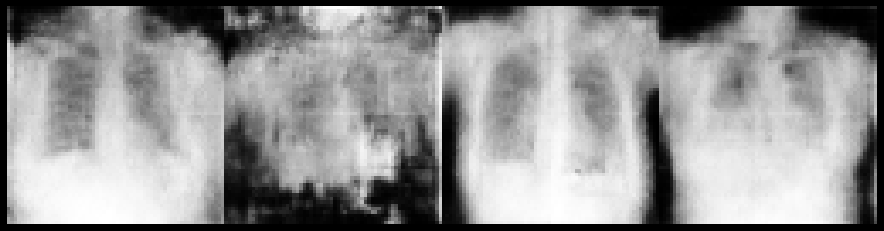

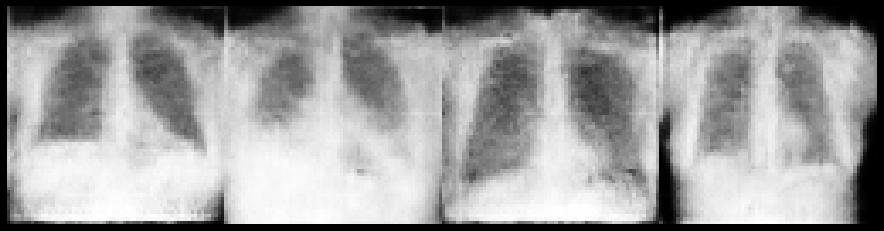

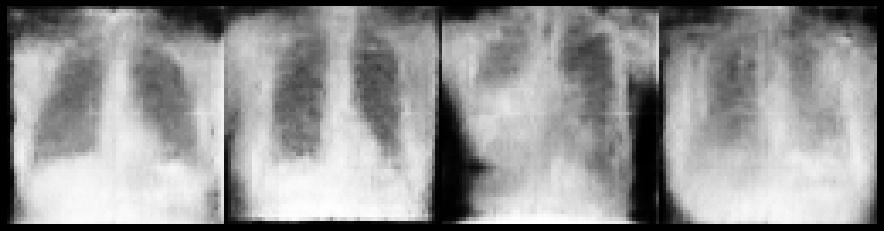

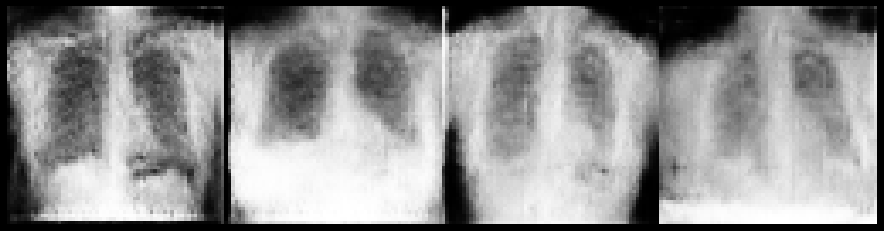

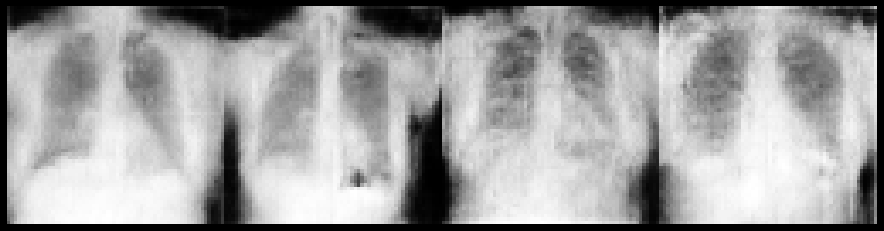

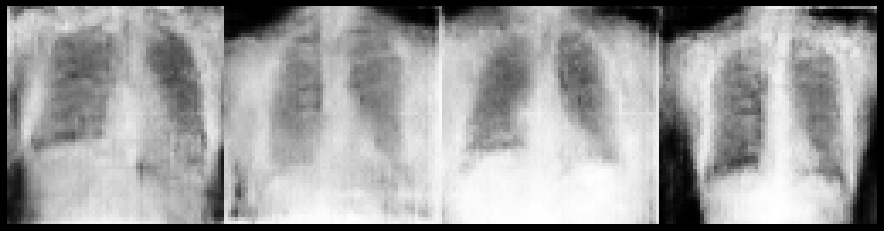

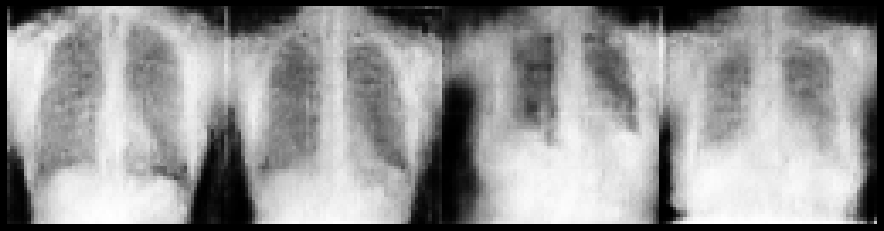

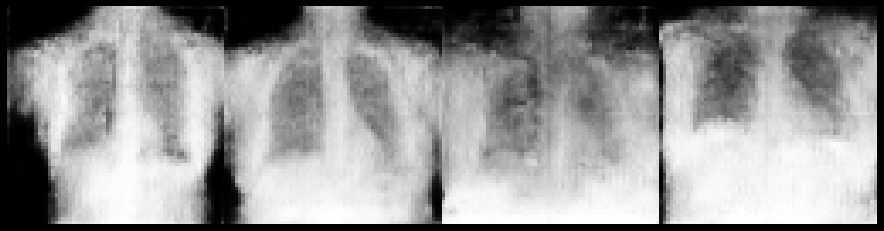

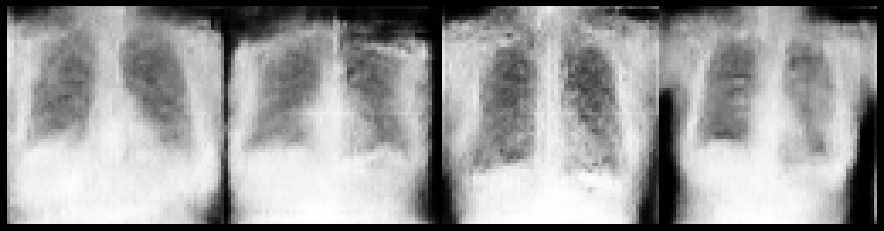

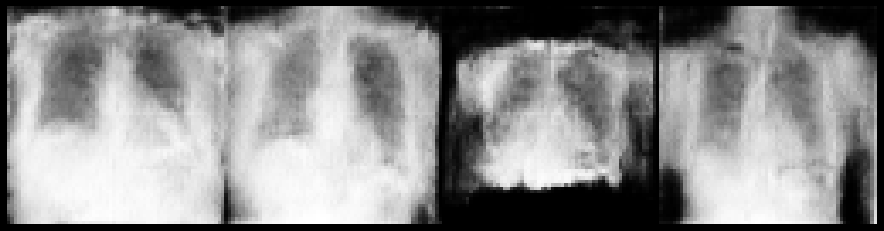

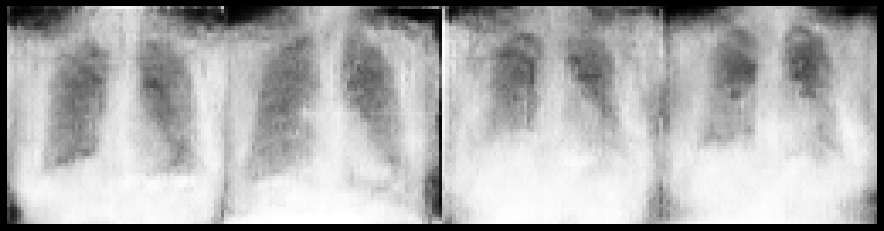

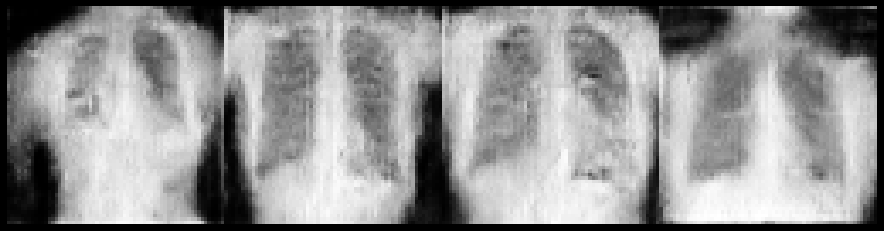

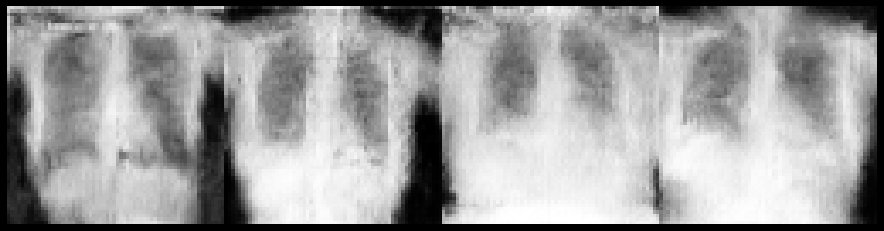

In [21]:
EPOCHS = 100
history = chest_gan.fit(dataset, epochs=EPOCHS, callbacks=[ShowFake()])

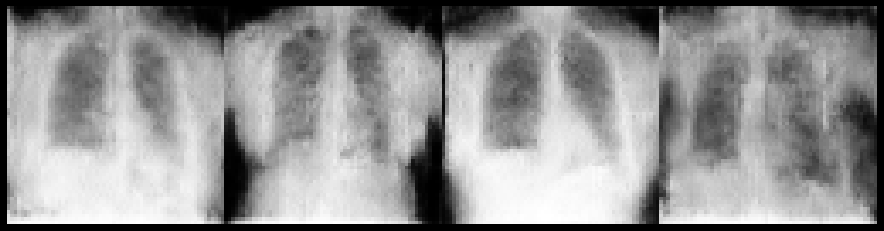

In [22]:
chest_gan.show_fake(f'img-epoch{EPOCHS}.png')

In [23]:
def loss_curves(history):
    num_curves = len(history.history) - 1
    fig, axes = plt.subplots(num_curves, 1, figsize=(4, 4*num_curves), sharex=True)
    for i, loss in enumerate(history.history):
        if loss=='ssim':
            continue
        axes[i].plot(history.history[loss])
        axes[i].set_ylabel(loss.replace('g_', 'Generator ').replace('d_', 'Discriminator ').replace('clf_', 'Classification '))
    axes[-1].set_xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    fig.savefig('loss.png') 

def ssim_curve(history):
    fig = plt.figure(figsize=(4, 4))
    plt.plot(history.history['ssim'])
    plt.ylabel('SSIM')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    fig.savefig('ssim.png')

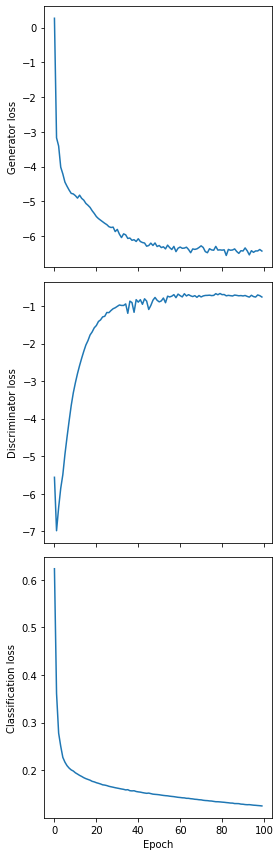

In [24]:
loss_curves(history)

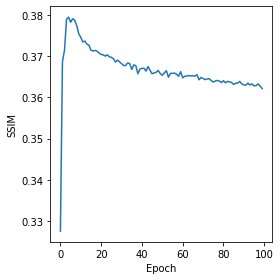

In [25]:
ssim_curve(history)

In [26]:
chest_gan.generator.save_weights("generator.h5")
chest_gan.discriminator.save_weights("discriminator.h5")

## Using the trained model

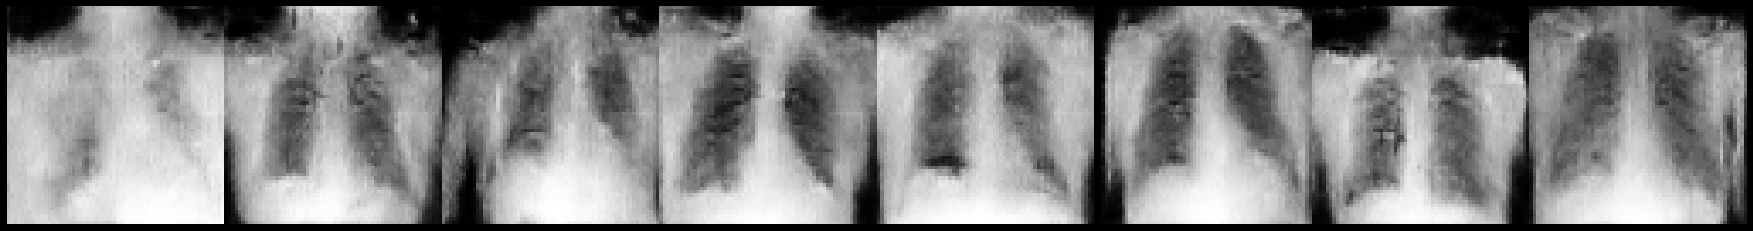

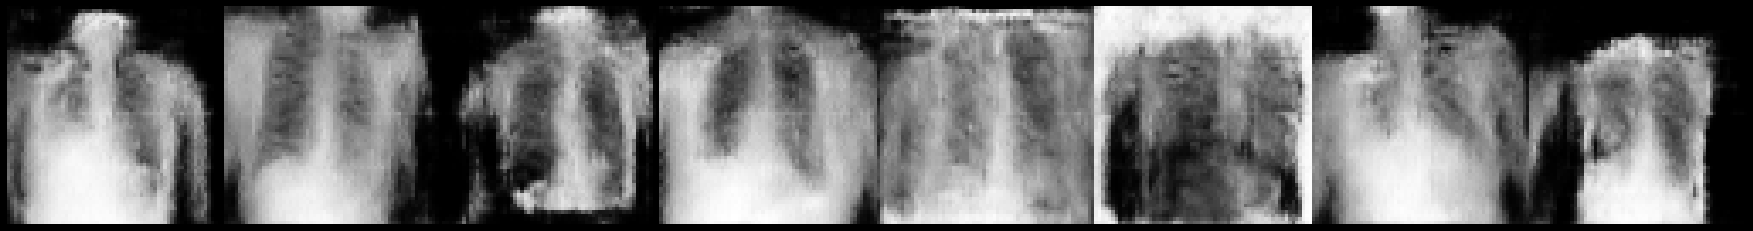

In [27]:
chest_gan.show_fake("healthy-male-ap.png", label=[0, 0, 0, 1, 1], num_images=8)
chest_gan.show_fake("healthy-female-ap.png", label=[0, 0, 0, 0, 1], num_images=8)

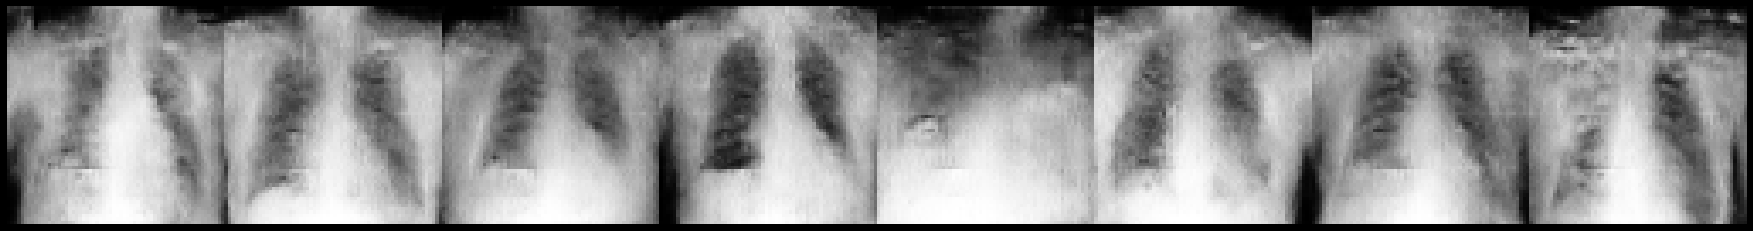

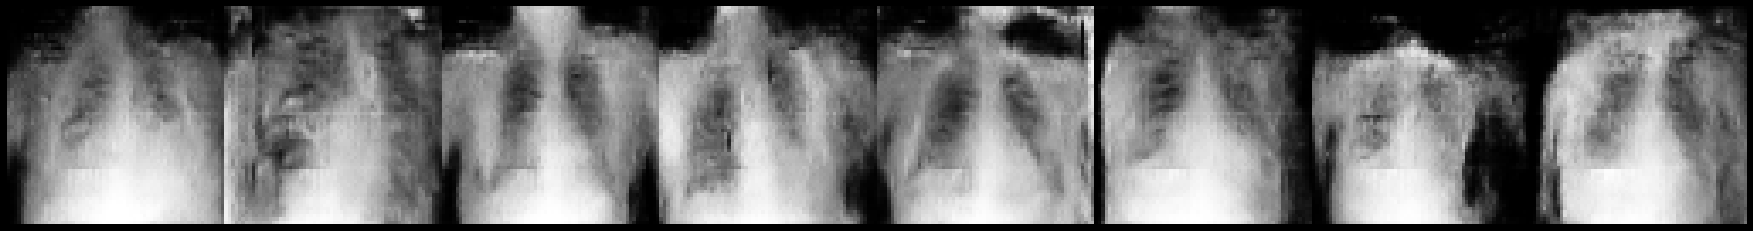

In [28]:
chest_gan.show_fake("cardiomegaly-male-ap.png", label=[1, 0, 0, 1, 1], num_images=8)
chest_gan.show_fake("cardiomegaly-female-ap.png", label=[1, 0, 0, 0, 1], num_images=8)

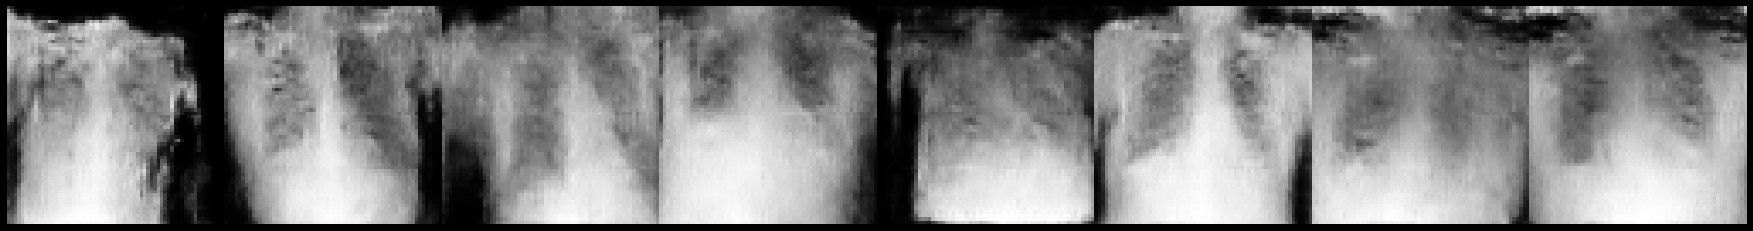

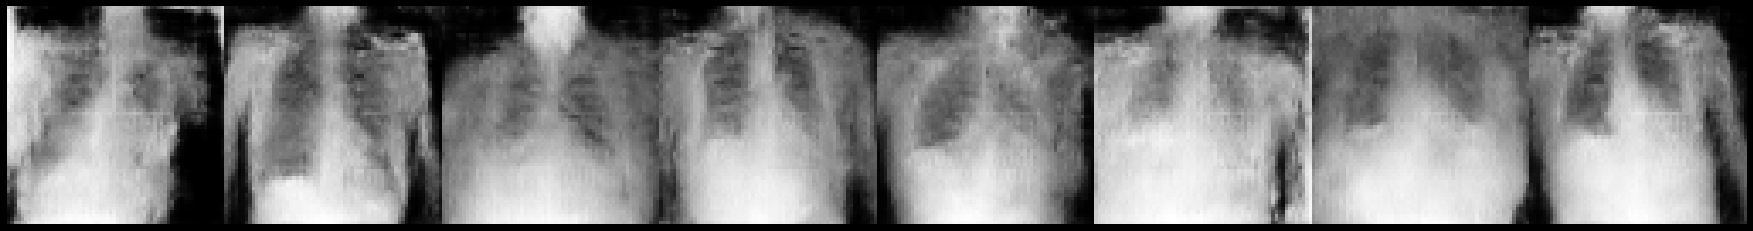

In [29]:
chest_gan.show_fake("infiltration-male-ap.png", label=[0, 0, 1, 1, 1], num_images=8)
chest_gan.show_fake("infiltration-female-ap.png", label=[0, 0, 1, 0, 1], num_images=8)